In [36]:
import numpy
import pandas as pd
import matplotlib.pyplot as plt
import copy
import yfinance as yf
from datetime import datetime, timedelta
import tensorflow as tf
from tensorflow import keras

In [37]:
"""Testing for a GPU"""

print("Is there a GPU available: "),
print(tf.config.list_physical_devices("GPU"))
x = tf.random.uniform([3, 3])

print("Is the Tensor on GPU #0:  "),
print(x.device.endswith('GPU:0'))

Is there a GPU available: 
[]
Is the Tensor on GPU #0:  
False


Data Preperation

In [38]:
"""Loading s&p 100 tickers"""

sample_tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'NVDA']

data = yf.download(sample_tickers, start="2015-01-01", end="2024-01-01")

close = data['Close']
volume = data['Volume']


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_34100\3007705281.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(sample_tickers, start="2015-01-01", end="2024-01-01")
[*********************100%***********************]  5 of 5 completed


In [39]:
close.head()

Ticker,AAPL,AMZN,GOOGL,MSFT,NVDA
Date,,,,,
2015-01-02,24.237547,15.4260,26.296135,39.858456,0.483038
2015-01-05,23.554741,15.1095,25.795086,39.491917,0.474880
2015-01-06,23.556959,14.7645,25.158482,38.912289,0.460482
2015-01-07,23.887281,14.9210,25.084490,39.406673,0.459282
2015-01-08,24.805086,15.0230,25.171888,40.565956,0.476559


In [40]:
close.tail()

Ticker,AAPL,AMZN,GOOGL,MSFT,NVDA
Date,,,,,
2023-12-22,191.788757,153.419998,140.520828,369.077087,48.805527
2023-12-26,191.243927,153.410004,140.550613,369.155945,49.254299
2023-12-27,191.342972,153.339996,139.408478,368.574615,49.392239
2023-12-28,191.768951,153.380005,139.269409,369.766876,49.497181
2023-12-29,190.728760,151.940002,138.733154,370.515686,49.497181


In [41]:
close_np = data['Close'].to_numpy()
volume_np = data['Volume'].to_numpy()

In [42]:
from technical_indicators import AddTechnicalIndicators

indicator_class = AddTechnicalIndicators(close, sample_tickers)
data = indicator_class.add_sma()
data = indicator_class.add_ema()
data = indicator_class.add_rsi()

data_frame = data 
data = data.to_numpy()




c:\Users\ADMIN\Documents\GitHub\IndividualProject\technical_indicators.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[name, 'SMA'] = data[name].rolling(window=window).mean()
c:\Users\ADMIN\Documents\GitHub\IndividualProject\technical_indicators.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[name, 'SMA'] = data[name].rolling(window=window).mean()
c:\Users\ADMIN\Documents\GitHub\IndividualProject\technical_indicators.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy o

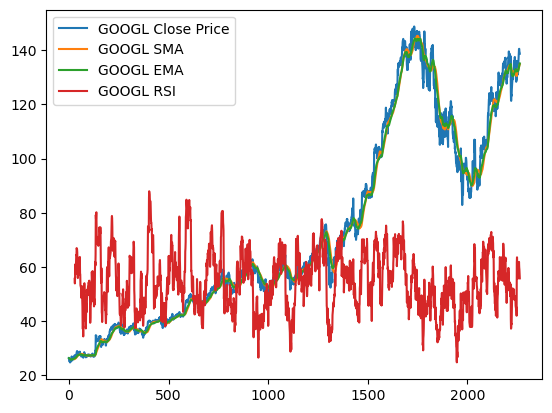

In [43]:
googl = data[:, 2]
googl_sma = data[:, 7]
googl_ema = data[:, 12]
googl_rsi = data[:, 17]

plt.plot(googl, label='GOOGL Close Price')
plt.plot(googl_sma, label='GOOGL SMA')
plt.plot(googl_ema, label='GOOGL EMA')
plt.plot(googl_rsi, label='GOOGL RSI')
plt.legend()
plt.show()

In [44]:
print(data.shape)

(2264, 20)


In [45]:
from numpy.lib.stride_tricks import sliding_window_view

def add_look_back(data, look_back):
    X, y = [], []
    for i in range(look_back, len(data)):
        X.append(data[i - look_back:i])
        y.append(data[i])
    return numpy.array(X), numpy.array(y)

In [46]:
lookback = 30
x, y = add_look_back(data, look_back=lookback)
print(x.shape)
print(y.shape)
print(close.shape)


(2234, 30, 20)
(2234, 20)
(2264, 20)


In [47]:
class RollingZScoreNorm:
    def __init__(self, data, look_back=30):
        self.data = data
    
    def get_rolling_z(self, window=30):
        """Add Rolling Z-Score to the data."""
        """Final Ouput must then me computed as """

        data = self.data
        normalized_data = copy.deepcopy(data)

        for col in self.data.columns:
            rolling_mean = data[col].rolling(window=window).mean()
            rolling_std = data[col].rolling(window=window).std()
            normalized_data[col] = (data[col] - rolling_mean) / rolling_std
        
        return normalized_data
    
    def inverse_transform(self, normalized_output, window=30):
        """normalized_output must be a numpy array"""
        """Inverse transform the normalized data back to original scale."""
        data = self.data
        inv_data = normalized_output.copy()


        for i in range(normalized_output.shape[0]):
            col = data.colums[i]
            rolling_mean = data[col].rolling(window=window).mean()
            rolling_std = data[col].rolling(window=window).std()
            inv_data[i] = (normalized_output[i] * rolling_std) + rolling_mean
        return inv_data
    


In [48]:
norm_class = RollingZScoreNorm(data_frame)
norm_data = norm_class.get_rolling_z(window=lookback)
print(norm_data.to_numpy())
print(norm_data.to_numpy().shape)


[[        nan         nan         nan ...         nan         nan
          nan]
 [        nan         nan         nan ...         nan         nan
          nan]
 [        nan         nan         nan ...         nan         nan
          nan]
 ...
 [ 0.18510066  1.57639594  1.52544276 ...  0.95577922 -0.51975217
  -1.59459663]
 [ 0.2743805   1.46544447  1.37385484 ...  0.67256218 -1.29797627
  -1.91640601]
 [-0.15463992  0.99357055  1.13776793 ...  0.38532645 -0.78078373
  -1.36682222]]
(2264, 20)


In [49]:
norm_data.to_numpy()[29]

array([ 2.04644725,  1.58664543,  1.8479124 , -0.25925919,  2.83378353,
               nan,         nan,         nan,         nan,         nan,
        2.4416386 , -1.72225969,  1.75934686,  2.39189523,  3.5049972 ,
               nan,         nan,         nan,         nan,         nan])

In [50]:
# dataset = norm_data.to_numpy()

# for i in range(len(dataset)):
#     dataset[i][-1] = 

In [51]:

x, y = add_look_back(norm_data.to_numpy(), look_back=lookback)
print(x.shape)
print(y.shape)
print(close.shape)

X = x
Y = y[:, :5]

(2234, 30, 20)
(2234, 20)
(2264, 20)


In [52]:
print(Y[0])

[ 1.94261461  1.30639153  1.37298655 -0.21293648  2.49397242]


In [64]:
print(x[59])

[[-2.98504160e-01 -3.89253766e-01  4.99769212e-02 -1.64145265e+00
  -1.51460096e+00  1.03696519e+00 -9.95743742e-01  1.36277886e+00
   8.78618893e-01  1.27574612e+00  8.41940803e-01 -1.91027343e+00
   1.20783336e+00  9.41186469e-01  8.38451300e-01 -1.83717174e+00
  -1.52751675e+00 -1.83342546e+00 -1.59330534e+00 -2.52090658e+00]
 [-9.88132063e-01 -7.90942069e-01 -4.99756059e-01 -1.75198723e+00
  -2.13261726e+00  9.66885120e-01 -1.16327841e+00  1.31415768e+00
   8.27707189e-01  1.15154053e+00  8.07512969e-01 -1.94679647e+00
   1.12065471e+00  9.26819529e-01  6.66329519e-01 -1.97642726e+00
  -1.61144070e+00 -1.81628823e+00 -1.35161056e+00 -2.52714131e+00]
 [-9.89619500e-01 -1.07085692e+00 -9.65490600e-01 -1.56122198e+00
  -1.84476780e+00  8.87405738e-01 -1.32963918e+00  1.26584886e+00
   7.78927157e-01  1.04746640e+00  7.68784385e-01 -1.94592136e+00
   1.00658779e+00  9.01967037e-01  5.01338489e-01 -1.92551058e+00
  -1.42721792e+00 -1.89646106e+00 -1.25126897e+00 -2.05789555e+00]
 [-5.48

In [54]:
print(x)

[[[        nan         nan         nan ...         nan         nan
           nan]
  [        nan         nan         nan ...         nan         nan
           nan]
  [        nan         nan         nan ...         nan         nan
           nan]
  ...
  [        nan         nan         nan ...         nan         nan
           nan]
  [        nan         nan         nan ...         nan         nan
           nan]
  [ 2.04644725  1.58664543  1.8479124  ...         nan         nan
           nan]]

 [[        nan         nan         nan ...         nan         nan
           nan]
  [        nan         nan         nan ...         nan         nan
           nan]
  [        nan         nan         nan ...         nan         nan
           nan]
  ...
  [        nan         nan         nan ...         nan         nan
           nan]
  [ 2.04644725  1.58664543  1.8479124  ...         nan         nan
           nan]
  [ 1.94261461  1.30639153  1.37298655 ...         nan         nan
      

In [ ]:
X =x[59:]
Y =y[59:]

Basic Model

In [55]:
from keras import layers, Sequential

In [56]:
model = keras.Sequential()

model.add(layers.Dense(512, input_shape=(lookback, 20)))
model.add(layers.Dropout(0.1))
model.add(layers.LeakyReLU(alpha=0.1))
model.add(layers.Dense(256))
model.add(layers.Dropout(0.1))

model.add(layers.LeakyReLU(alpha=0.1))
model.add(layers.Dense(128)) 
model.add(layers.Dropout(0.1))
model.add(layers.LeakyReLU(alpha=0.1))
model.add(layers.Dense(5, activation='linear'))


model.compile(optimizer='adam', loss='mse', metrics=['mae'])

c:\Users\ADMIN\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\ADMIN\anaconda3\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [ ]:
# model.fit(X,Y, epochs=1, batch_size=32)

Test and Visuals

In [ ]:
preds = model.predict(X)

In [ ]:
plt.plot(Y, label='True Values')
plt.plot(preds, label='Predicted Values')